In [23]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import confusion_matrix,accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

In [15]:
data=pd.read_csv("/content/Telco Customer Churn.csv")
print(data.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [17]:
# Drop customerID as it is not useful
data = data.drop('customerID', axis=1)

# Convert total charges to numeric (some may be blank)
data['TotalCharges'] = pd.to_numeric(data['TotalCharges'], errors='coerce')
data['TotalCharges'] = data['TotalCharges'].fillna(data['TotalCharges'].median())

# Encode categorical columns
for col in data.select_dtypes(include=['object']).columns:
    if col != 'Churn':  # Churn is target
        data[col] = LabelEncoder().fit_transform(data[col])

# Encode target
data['Churn'] = LabelEncoder().fit_transform(data['Churn'])

# Split features and target
X = data.drop('Churn', axis=1).values
y = data['Churn'].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train = torch.tensor(scaler.fit_transform(X_train), dtype=torch.float32)
X_test = torch.tensor(scaler.transform(X_test), dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)


In [18]:
class ANN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_dim = X_train.shape[1]  # number of features
model = ANN(input_dim=input_dim, hidden_dim=32, output_dim=2)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [19]:
epochs = 100

for epoch in range(epochs):
    optimizer.zero_grad()
    outputs = model(X_train)
    loss = criterion(outputs, y_train)
    loss.backward()
    optimizer.step()

    if (epoch+1) % 20 == 0:
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}")


Epoch [20/100], Loss: 0.5720
Epoch [40/100], Loss: 0.5041
Epoch [60/100], Loss: 0.4692
Epoch [80/100], Loss: 0.4503
Epoch [100/100], Loss: 0.4389


Test Accuracy: 0.8084


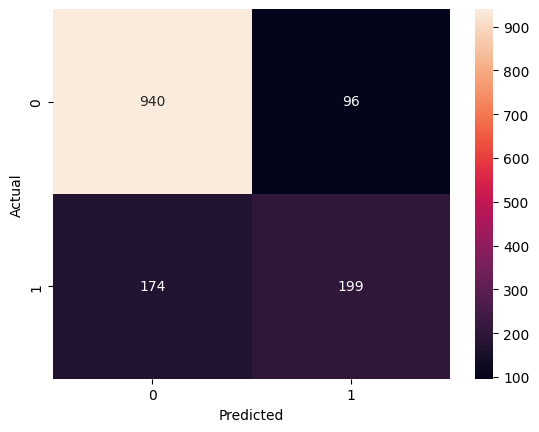

In [24]:
with torch.no_grad():
    y_pred = torch.argmax(model(X_test), axis=1)
    acc = accuracy_score(y_test, y_pred)
    print(f"Test Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
